<a href="https://colab.research.google.com/github/dyfzl/AI-JBNU/blob/main/%EC%9E%91%EA%B0%80%EC%9D%98_%EB%AC%B8%EC%B2%B4%EB%A5%BC_%ED%95%99%EC%8A%B5%ED%95%9C_%ED%85%8D%EC%8A%A4%ED%8A%B8_%EC%83%9D%EC%84%B1_%EB%B0%8F_%EA%B0%90%EC%84%B1%EB%B6%84%EC%84%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
import os

# WandB 비활성화
os.environ["WANDB_DISABLED"] = "true"


In [4]:
import pandas as pd
import os
from google.colab import drive
drive.mount('/content/drive/')

# 데이터 로드
train = pd.read_csv('/content/drive/MyDrive/소설작가분류/train.csv')
test = pd.read_csv('/content/drive/MyDrive/소설작가분류/test_x.csv')


Mounted at /content/drive/


In [5]:
# 데이터 확인
df = train
author_counts = df['author'].value_counts()
print(author_counts)

# 특정 작가(author=3)의 데이터 필터링 및 전처리
import re
def clean_text_preserve_style(text):
    text = re.sub(r"[^\w\s.,!?']", "", text)  # 특수문자 중 쉼표, 마침표 등 유지
    text = re.sub(r"\s+", " ", text).strip()  # 불필요한 공백 제거
    return text

author_data = df[df['author'] == 3]
author_data["text"] = author_data["text"].apply(clean_text_preserve_style)


author
3    15063
0    13235
2    11554
4     7805
1     7222
Name: count, dtype: int64


<ipython-input-5-6f4169ac472e>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  author_data["text"] = author_data["text"].apply(clean_text_preserve_style)


In [6]:

# Hugging Face 모델 준비 (GPT-2)
from transformers import GPT2Tokenizer, GPT2LMHeadModel
model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)

# Padding token 추가
tokenizer.pad_token = tokenizer.eos_token
model.resize_token_embeddings(len(tokenizer))


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Embedding(50257, 768)

In [9]:

# 데이터셋 준비 및 전처리
from sklearn.model_selection import train_test_split
from datasets import Dataset

train_data, eval_data = train_test_split(author_data, test_size=0.1, random_state=42)
train_dataset = Dataset.from_pandas(train_data[["text"]])
eval_dataset = Dataset.from_pandas(eval_data[["text"]])

def preprocess_data_with_labels(examples):
    inputs = tokenizer(
        examples["text"], max_length=512, truncation=True, padding="max_length"
    )
    inputs["labels"] = inputs["input_ids"]
    return inputs

train_dataset = train_dataset.map(preprocess_data_with_labels, batched=True)
eval_dataset = eval_dataset.map(preprocess_data_with_labels, batched=True)

train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
eval_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])


Map:   0%|          | 0/13556 [00:00<?, ? examples/s]

Map:   0%|          | 0/1507 [00:00<?, ? examples/s]

In [33]:
from transformers import Trainer, TrainingArguments, GPT2Tokenizer, GPT2LMHeadModel
from datasets import Dataset
import pandas as pd
import re
from sklearn.model_selection import train_test_split

# 학습 설정
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    save_steps=1000,
    evaluation_strategy="steps",
    eval_steps=1000,
    logging_dir="./logs",
    logging_steps=500,
    learning_rate=3e-5,
    warmup_steps=100,
    weight_decay=0.01,
    fp16=True,
    report_to="none",
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
)

# 모델 학습
trainer.train()

# 모델 저장
save_directory = "/content/fine_tuned_model"
trainer.save_model(save_directory)
tokenizer.save_pretrained(save_directory)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-33-0fccad3d7c19>:25: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss
1000,0.326000,0.332730
2000,0.312500,0.332023
3000,0.316300,0.329688
4000,0.306000,0.329905
5000,0.318000,0.328715


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


('/content/fine_tuned_model/tokenizer_config.json',
 '/content/fine_tuned_model/special_tokens_map.json',
 '/content/fine_tuned_model/vocab.json',
 '/content/fine_tuned_model/merges.txt',
 '/content/fine_tuned_model/added_tokens.json')

In [21]:
from transformers import pipeline
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import pandas as pd

# 텍스트 생성 파이프라인
text_generator = pipeline("text-generation", model=model, tokenizer=tokenizer)

# 테스트 프롬프트 정의
test_prompts = ["We", "The day was bright", "she"]

# 참조 문장 리스트 (평가 데이터셋에서 더 많은 문장 사용)
reference_texts = eval_data["text"].tolist()[:1000]  # 참조 문장 1000개 추출
references = [[ref.split()] for ref in reference_texts]  # 각 참조 문장을 리스트의 리스트로 처리

# BLEU 점수 계산 함수 정의
def calculate_bleu(candidate, references):
    smoothing = SmoothingFunction().method1
    return sentence_bleu([ref[0] for ref in references], candidate, weights=(0.5, 0.5), smoothing_function=smoothing)

# 결과 저장용 리스트
results = []

# 각 프롬프트에 대해 텍스트 생성 및 BLEU 점수 계산
for prompt in test_prompts:
    generated_text = text_generator(prompt, max_length=100, num_return_sequences=1)[0]["generated_text"]
    candidate = generated_text.strip().split()  # 생성된 문장 토큰화
    bleu_score = calculate_bleu(candidate, references)  # BLEU 점수 계산
    results.append({"Prompt": prompt, "Generated Text": generated_text, "BLEU Score": bleu_score})

# 결과 출력
for result in results:
    print(f"--- Prompt: {result['Prompt']} ---")
    print(f"Generated Text: {result['Generated Text']}")
    print(f"BLEU Score: {result['BLEU Score']:.4f}")
    print("-" * 50)


Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


--- Prompt: We ---
Generated Text: We have no doubt about that, but I am sure you may very well be quite right. You are all quite right!
BLEU Score: 0.7977
--------------------------------------------------
--- Prompt: The day was bright ---
Generated Text: The day was bright, the clouds were thick, and odin gazed at them in silence. When odin and odin were about to depart, they all came to a great and decisive stand on the road.
BLEU Score: 0.6921
--------------------------------------------------
--- Prompt: she ---
Generated Text: she, odin, my dear odin, I beg you to forgive what she said, odin, but do you know the meaning of it?
BLEU Score: 0.8452
--------------------------------------------------


In [22]:
from transformers import pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import pandas as pd

# 감정 분석 모델 설정
sentiment_analyzer = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

# 유사 문장 찾기: 상위 8000개의 참조 문장을 비교
def find_related_sentences(prompts, data, top_n=8000):
    all_sentences = data['text'].tolist()
    vectorizer = TfidfVectorizer()
    sentence_vectors = vectorizer.fit_transform(all_sentences)

    related_sentences = []
    for prompt in prompts:
        prompt_vector = vectorizer.transform([prompt])
        similarities = cosine_similarity(prompt_vector, sentence_vectors).flatten()
        top_indices = similarities.argsort()[-top_n:][::-1]
        top_related = [all_sentences[i] for i in top_indices]
        related_sentences.append(top_related)
    return related_sentences

# BLEU 점수 계산 함수
def calculate_bleu_with_multiple_references(generated, references):
    bleu_scores = []
    smoothing = SmoothingFunction().method1
    for gen_text, ref_texts in zip(generated, references):
        ref_tokens = [ref.split() for ref in ref_texts]  # 참조 문장 토큰화
        gen_tokens = gen_text.split()  # 생성된 텍스트 토큰화
        bleu_score = sentence_bleu(ref_tokens, gen_tokens, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothing)
        bleu_scores.append(bleu_score)
    return bleu_scores

# 감정 분석 함수
def analyze_sentiments(texts):
    sentiment_mapping = {
        "POSITIVE": "Positive",
        "NEGATIVE": "Negative",
        "NEUTRAL": "Neutral"
    }
    sentiments = []
    for text in texts:
        sentiment = sentiment_analyzer(text)
        label = sentiment[0]['label']
        sentiments.append(sentiment_mapping.get(label, "Unknown"))
    return sentiments

# 테스트 프롬프트
test_prompts = ["We", "The day was bright", "she"]

# 텍스트 생성
generated_texts = [
    text_generator(prompt, max_length=100, num_return_sequences=1)[0]["generated_text"]
    for prompt in test_prompts
]

# 참조 문장 선택 (상위 8000개)
top_n = 8000
similar_sentences = find_related_sentences(test_prompts, eval_data, top_n)

# BLEU 점수 계산
bleu_scores = calculate_bleu_with_multiple_references(generated_texts, similar_sentences)

# 감정 분석 수행
generated_sentiments = analyze_sentiments(generated_texts)

# 상위 5개 참조 문장만 출력하도록 설정
top_5_sentences = [["\n".join(sentences[:5])] for sentences in similar_sentences]

# 결과 데이터프레임 생성
results_df = pd.DataFrame({
    "Prompt": test_prompts,
    "Generated Text": generated_texts,
    "Sentiment": generated_sentiments,
    "BLEU Score": bleu_scores,
    "Top Similar Sentences (Top 5)": [sentences[0] for sentences in top_5_sentences]
})

# 결과 출력
def display_results_with_sentiments(df):
    for index, row in df.iterrows():
        print(f"\n--- Prompt {index + 1} ---")
        print(f"Prompt: {row['Prompt']}")
        print(f"Generated Text: {row['Generated Text']}")
        print(f"Sentiment: {row['Sentiment']}")
        print(f"BLEU Score: {row['BLEU Score']:.4f}")
        print("Top 5 Similar Sentences:")
        print(row["Top Similar Sentences (Top 5)"])
        print("-" * 50)

# BLEU 점수와 감정 분석 결과 출력
display_results_with_sentiments(results_df)


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.



--- Prompt 1 ---
Prompt: We
Generated Text: We have seen your letter and all. We must ask you to read your letter and all. And do you understand how I have to read your letter to make sure you do. I am sure you are going to read it yourself already, and to send it. If you like, I can ask odin to do the same for you. I have a copy of every one of them too.
Sentiment: Positive
BLEU Score: 0.2287
Top 5 Similar Sentences:
No, no we all want it.
I was standing at the gate with them... dont you remember? We have carried on our trade in that house for years past. We cure and prepare hides, we take work home... most of all I was vexed....
You think we may become friends?
I believe we can say _goodbye_!
You shall have some, too, when we get home.
--------------------------------------------------

--- Prompt 2 ---
Prompt: The day was bright
Generated Text: The day was bright, bright as ever, except that the rain in the garden had made a chill through the soil. The heat was oppressive. The sun 


--- Prompt 1 ---
Prompt: We
Generated Text: We have seen your letter and all. We must ask you to read your letter and all. And do you understand how I have to read your letter to make sure you do. I am sure you are going to read it yourself already, and to send it. If you like, I can ask odin to do the same for you. I have a copy of every one of them too.
Sentiment: Positive
BLEU Score: 0.2287
Top 5 Similar Sentences:
No, no we all want it.
I was standing at the gate with them... dont you remember? We have carried on our trade in that house for years past. We cure and prepare hides, we take work home... most of all I was vexed....
You think we may become friends?
I believe we can say _goodbye_!
You shall have some, too, when we get home.
--------------------------------------------------

--- Prompt 2 ---
Prompt: The day was bright
Generated Text: The day was bright, bright as ever, except that the rain in the garden had made a chill through the soil. The heat was oppressive. The sun 

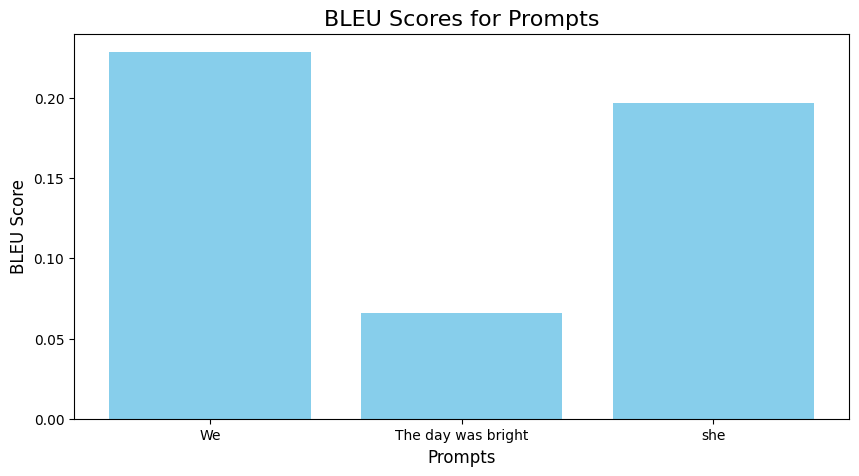

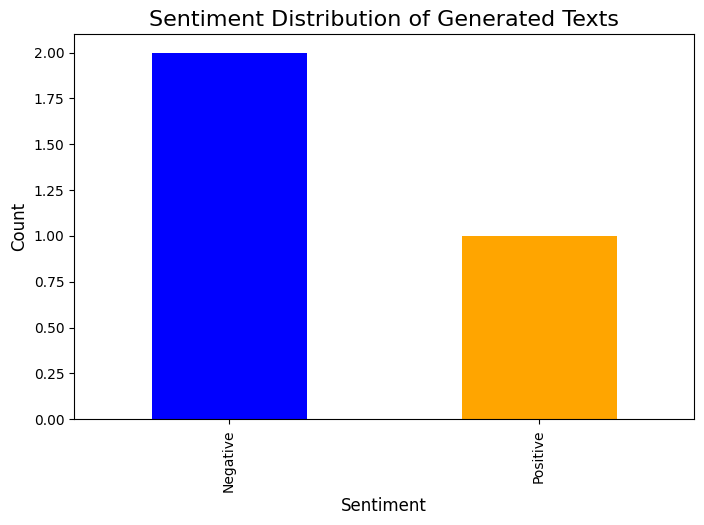

In [31]:
import matplotlib.pyplot as plt


# 시각화 함수
def visualize_results(df):
    # BLEU 점수 시각화
    plt.figure(figsize=(10, 5))
    plt.bar(df["Prompt"], df["BLEU Score"], color="skyblue")
    plt.title("BLEU Scores for Prompts", fontsize=16)
    plt.xlabel("Prompts", fontsize=12)
    plt.ylabel("BLEU Score", fontsize=12)
    plt.show()

    # 감정 분석 분포 시각화
    sentiment_counts = df["Sentiment"].value_counts()
    plt.figure(figsize=(8, 5))
    sentiment_counts.plot(kind="bar", color=["blue", "orange", "green"])
    plt.title("Sentiment Distribution of Generated Texts", fontsize=16)
    plt.xlabel("Sentiment", fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.show()

# 참조 문장 선택 (상위 8000개)
top_n = 8000
similar_sentences = find_related_sentences(test_prompts, eval_data, top_n)

# 상위 5개 참조 문장만 추출
top_5_sentences = [
    "\n".join(sentences[:5])  # 상위 5개의 문장만 선택 후 줄바꿈으로 연결
    for sentences in similar_sentences
]

# 결과 데이터프레임 생성
results_df = pd.DataFrame({
    "Prompt": test_prompts,
    "Generated Text": generated_texts,
    "Sentiment": generated_sentiments,
    "BLEU Score": bleu_scores,
    "Top Similar Sentences (Top 5)": top_5_sentences  # 상위 5개 참조 문장 추가
})


# BLEU 점수와 관련 문장 출력
display_results_with_sentiments(results_df)

# 시각화 출력
visualize_results(results_df)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.



--- Comparison for Prompt 1 ---
Prompt: We

Trained Model:
Generated Text: We have seen your letter and all. We must ask you to read your letter and all. And do you understand how I have to read your letter to make sure you do. I am sure you are going to read it yourself already, and to send it. If you like, I can ask odin to do the same for you. I have a copy of every one of them too.
Sentiment: Positive
BLEU Score: 0.2287

Untrained Model:
Generated Text: We just hope you understand and respect the law after it is read," said Mr Foa.

There was no immediate comment from the state police.

The group is based in Brisbane and is part of its own online group: "Black Lives Matter Australia".

A spokeswoman for the group later tweeted: "This is a hate crime of all kinds. No, we won't tolerate racism, bigotry, homophobia or Islamophobia. We will always stand up for all of us against prejudice
Sentiment: Negative
BLEU Score: 0.0410
--------------------------------------------------

--- Com

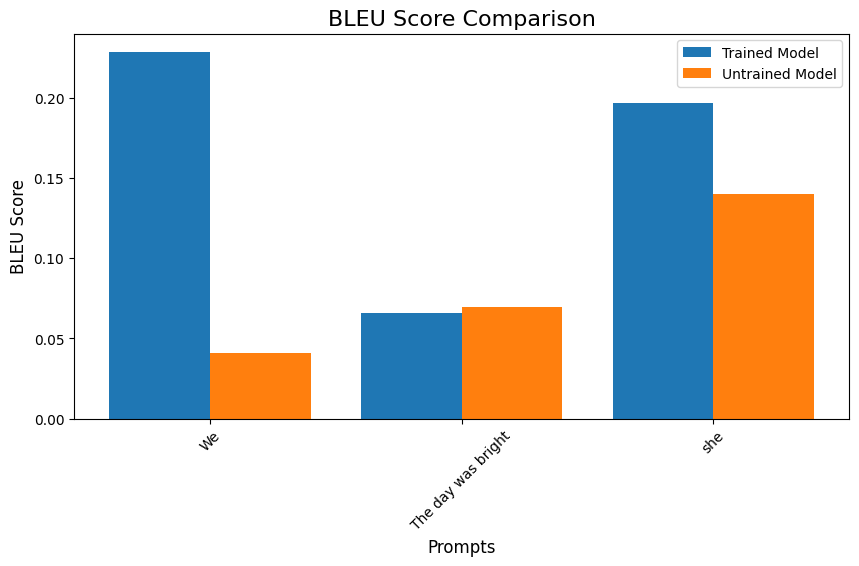

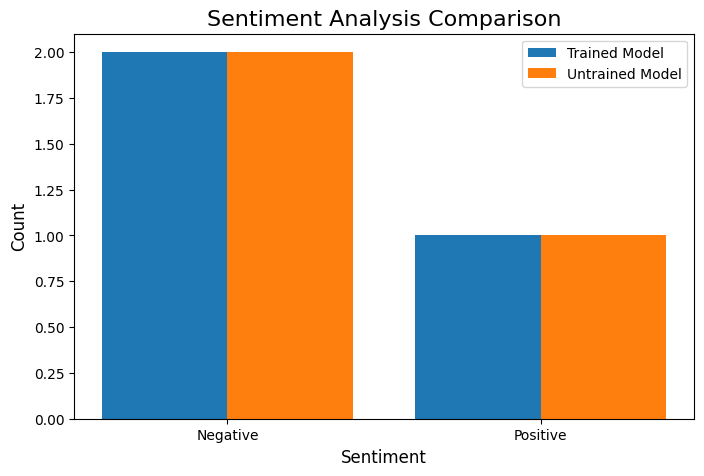

In [32]:
# 문체 학습시키지 않은 기본 GPT-2 모델 불러오기
untrained_model = GPT2LMHeadModel.from_pretrained("gpt2")
untrained_tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
untrained_tokenizer.pad_token = untrained_tokenizer.eos_token
untrained_model.resize_token_embeddings(len(untrained_tokenizer))

# 텍스트 생성 파이프라인 설정 (기본 모델)
untrained_text_generator = pipeline("text-generation", model=untrained_model, tokenizer=untrained_tokenizer)

# 테스트 프롬프트에 대해 텍스트 생성 (기본 모델)
untrained_generated_texts = [
    untrained_text_generator(prompt, max_length=100, num_return_sequences=1)[0]["generated_text"]
    for prompt in test_prompts
]

# BLEU 점수 계산 (기본 모델)
untrained_bleu_scores = calculate_bleu_with_multiple_references(untrained_generated_texts, similar_sentences)

# 감정 분석 수행 (기본 모델)
untrained_generated_sentiments = analyze_sentiments(untrained_generated_texts)

# 결과 데이터프레임 생성 (기본 모델)
untrained_results_df = pd.DataFrame({
    "Prompt": test_prompts,
    "Generated Text": untrained_generated_texts,
    "Sentiment": untrained_generated_sentiments,
    "BLEU Score": untrained_bleu_scores,
})

# 학습된 모델과 비교 데이터프레임 통합
comparison_df = pd.DataFrame({
    "Prompt": test_prompts,
    "Trained Generated Text": generated_texts,
    "Trained Sentiment": generated_sentiments,
    "Trained BLEU Score": bleu_scores,
    "Untrained Generated Text": untrained_generated_texts,
    "Untrained Sentiment": untrained_generated_sentiments,
    "Untrained BLEU Score": untrained_bleu_scores,
})

# 학습된 모델과 학습되지 않은 모델 비교 출력
def compare_models(df):
    for index, row in df.iterrows():
        print(f"\n--- Comparison for Prompt {index + 1} ---")
        print(f"Prompt: {row['Prompt']}")

        print("\nTrained Model:")
        print(f"Generated Text: {row['Trained Generated Text']}")
        print(f"Sentiment: {row['Trained Sentiment']}")
        print(f"BLEU Score: {row['Trained BLEU Score']:.4f}")

        print("\nUntrained Model:")
        print(f"Generated Text: {row['Untrained Generated Text']}")
        print(f"Sentiment: {row['Untrained Sentiment']}")
        print(f"BLEU Score: {row['Untrained BLEU Score']:.4f}")
        print("-" * 50)

# 비교 결과 출력
compare_models(comparison_df)

# 시각화를 통해 비교
def visualize_comparison(df):
    # BLEU 점수 비교
    plt.figure(figsize=(10, 5))
    x = range(len(df["Prompt"]))
    plt.bar(x, df["Trained BLEU Score"], width=0.4, label="Trained Model", align="center")
    plt.bar([p + 0.4 for p in x], df["Untrained BLEU Score"], width=0.4, label="Untrained Model", align="center")
    plt.xticks([p + 0.2 for p in x], df["Prompt"], rotation=45)
    plt.title("BLEU Score Comparison", fontsize=16)
    plt.xlabel("Prompts", fontsize=12)
    plt.ylabel("BLEU Score", fontsize=12)
    plt.legend()
    plt.show()

    # 감정 분석 결과 비교
    trained_sentiment_counts = df["Trained Sentiment"].value_counts()
    untrained_sentiment_counts = df["Untrained Sentiment"].value_counts()

    sentiments = list(set(trained_sentiment_counts.index).union(set(untrained_sentiment_counts.index)))
    trained_counts = [trained_sentiment_counts.get(sent, 0) for sent in sentiments]
    untrained_counts = [untrained_sentiment_counts.get(sent, 0) for sent in sentiments]

    bar_width = 0.4
    x = range(len(sentiments))

    plt.figure(figsize=(8, 5))
    plt.bar(x, trained_counts, width=bar_width, label="Trained Model", align="center")
    plt.bar([p + bar_width for p in x], untrained_counts, width=bar_width, label="Untrained Model", align="center")
    plt.xticks([p + bar_width / 2 for p in x], sentiments)
    plt.title("Sentiment Analysis Comparison", fontsize=16)
    plt.xlabel("Sentiment", fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.legend()
    plt.show()

# 시각화 결과 출력
visualize_comparison(comparison_df)
